In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
from utils import observe_condition, observe_cell_types

adata = sc.read_h5ad("../nCoV_dataset_full.h5ad")

In [2]:
print("Observation keys before observing condition and cell types")
print(adata.obs.keys())

observe_condition(adata)
observe_cell_types(adata)

print("Observation keys after observing condition and cell types")
print(adata.obs.keys())

Observation keys before observing condition and cell types
Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'percent.mt',
       'seurat_clusters', 'cell_type', 'integrated_snn_res.0.8', 'Stage'],
      dtype='object')
Observation keys after observing condition and cell types
Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'batch', 'percent.mt',
       'seurat_clusters', 'cell_type', 'integrated_snn_res.0.8', 'Stage',
       'sample_name', 'condition', 'cell_type_name'],
      dtype='object')


/Users/jeremiah/QCB311-Final/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/2b/9ss_33w972731thsw5jz2w9m0000gn/T/ipykernel_30580/584349889.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(mono, resolution=0.5)


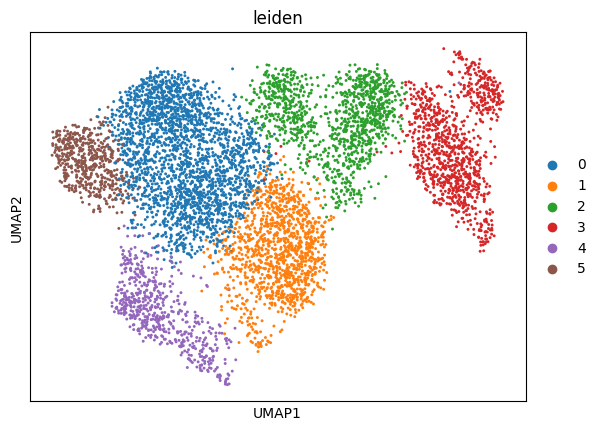

In [3]:
mono = adata[adata.obs["cell_type_name"] == "Cytotoxic CD8 T cells"].copy()

sc.pp.normalize_total(mono, target_sum=1e4)
sc.pp.log1p(mono)
sc.pp.pca(mono)
sc.pp.neighbors(mono)
sc.tl.umap(mono)
sc.tl.leiden(mono, resolution=0.5)

sc.pl.umap(mono, color=["leiden"])


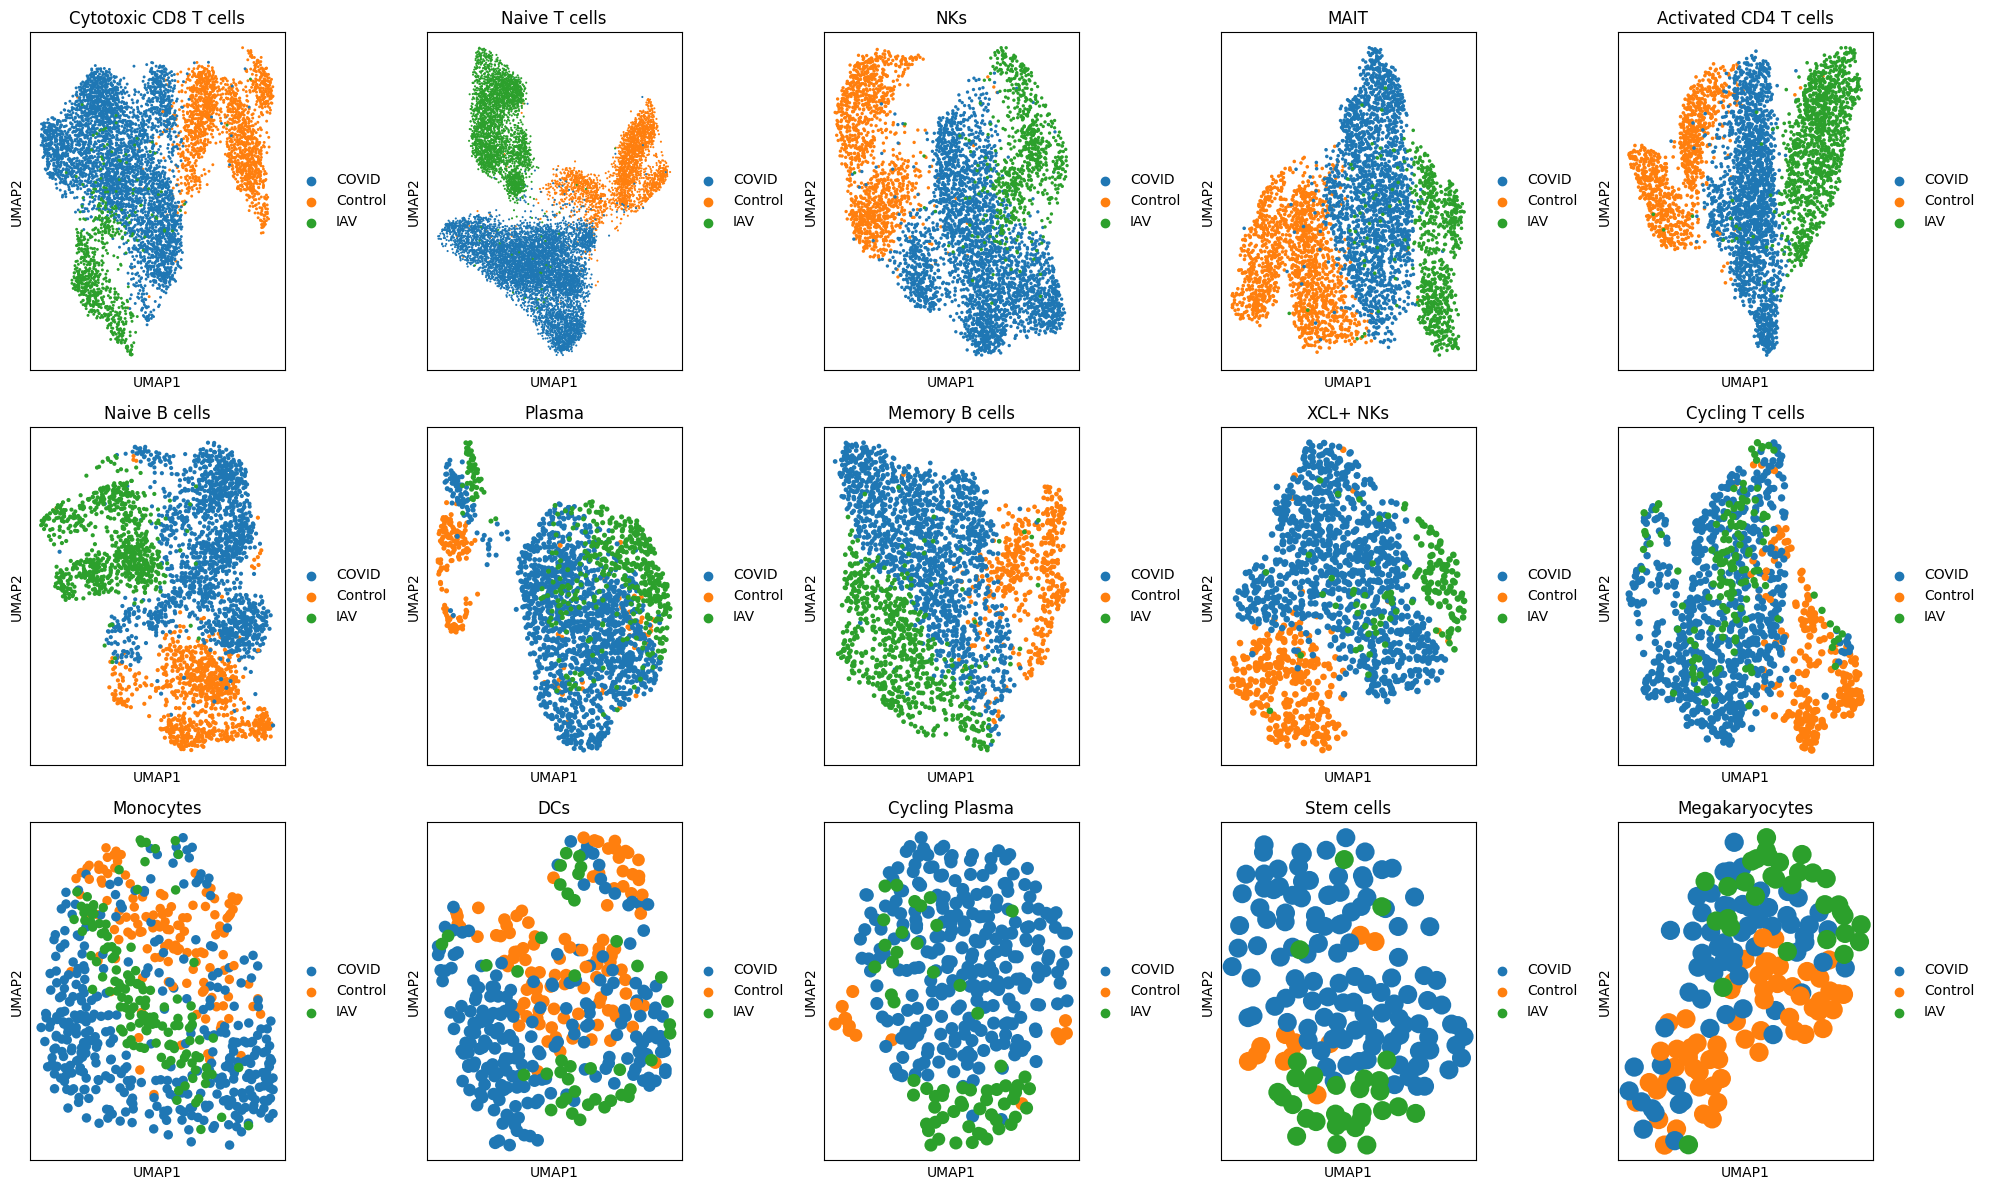

In [4]:
import scanpy as sc
import matplotlib.pyplot as plt

# Define the mapping from numeric ID to cell type
cell_type_mapping = {
    0: "Cytotoxic CD8 T cells",
    1: "Naive T cells",
    2: "NKs",
    3: "MAIT",
    4: "Activated CD4 T cells",
    5: "Naive B cells",
    6: "Plasma",
    7: "Memory B cells",
    8: "XCL+ NKs",
    9: "Cycling T cells",
    10: "Monocytes",
    11: "DCs",
    12: "Cycling Plasma",
    13: "Stem cells",
    14: "Megakaryocytes",
}

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
axes = axes.flatten()

# Loop through each cell type
for i, (cell_id, cell_name) in enumerate(cell_type_mapping.items()):
    ax = axes[i]
    subset = adata[adata.obs["cell_type"] == cell_id].copy()
    
    # Run full Scanpy pipeline on subset
    sc.pp.normalize_total(subset, target_sum=1e4)
    sc.pp.log1p(subset)
    sc.pp.pca(subset)
    sc.pp.neighbors(subset)
    sc.tl.umap(subset)
    sc.tl.leiden(subset, resolution=0.5)
    
    # Plot UMAP colored by condition
    sc.pl.umap(subset, color="condition", ax=ax, show=False, title=cell_name)

# Clean up empty subplot if there are fewer than 15 plots
for j in range(len(cell_type_mapping), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Trying resolution: 0.3
Number of clusters: 5
Trying resolution: 0.24
Number of clusters: 5
Trying resolution: 0.192
Number of clusters: 3
Trying resolution: 0.3
Number of clusters: 4
Trying resolution: 0.24
Number of clusters: 4
Trying resolution: 0.192
Number of clusters: 3
Trying resolution: 0.3
Number of clusters: 5
Trying resolution: 0.24
Number of clusters: 4
Trying resolution: 0.192
Number of clusters: 3
Trying resolution: 0.3
Number of clusters: 3
Trying resolution: 0.3
Number of clusters: 4
Trying resolution: 0.24
Number of clusters: 3
Trying resolution: 0.3
Number of clusters: 4
Trying resolution: 0.24
Number of clusters: 4
Trying resolution: 0.192
Number of clusters: 4
Trying resolution: 0.15360000000000001
Number of clusters: 3
Trying resolution: 0.3
Number of clusters: 3
Trying resolution: 0.3
Number of clusters: 3
Trying resolution: 0.3
Number of clusters: 3
Trying resolution: 0.3
Number of clusters: 4
Trying resolution: 0.24
Number of clusters: 4
Trying resolution: 0.192


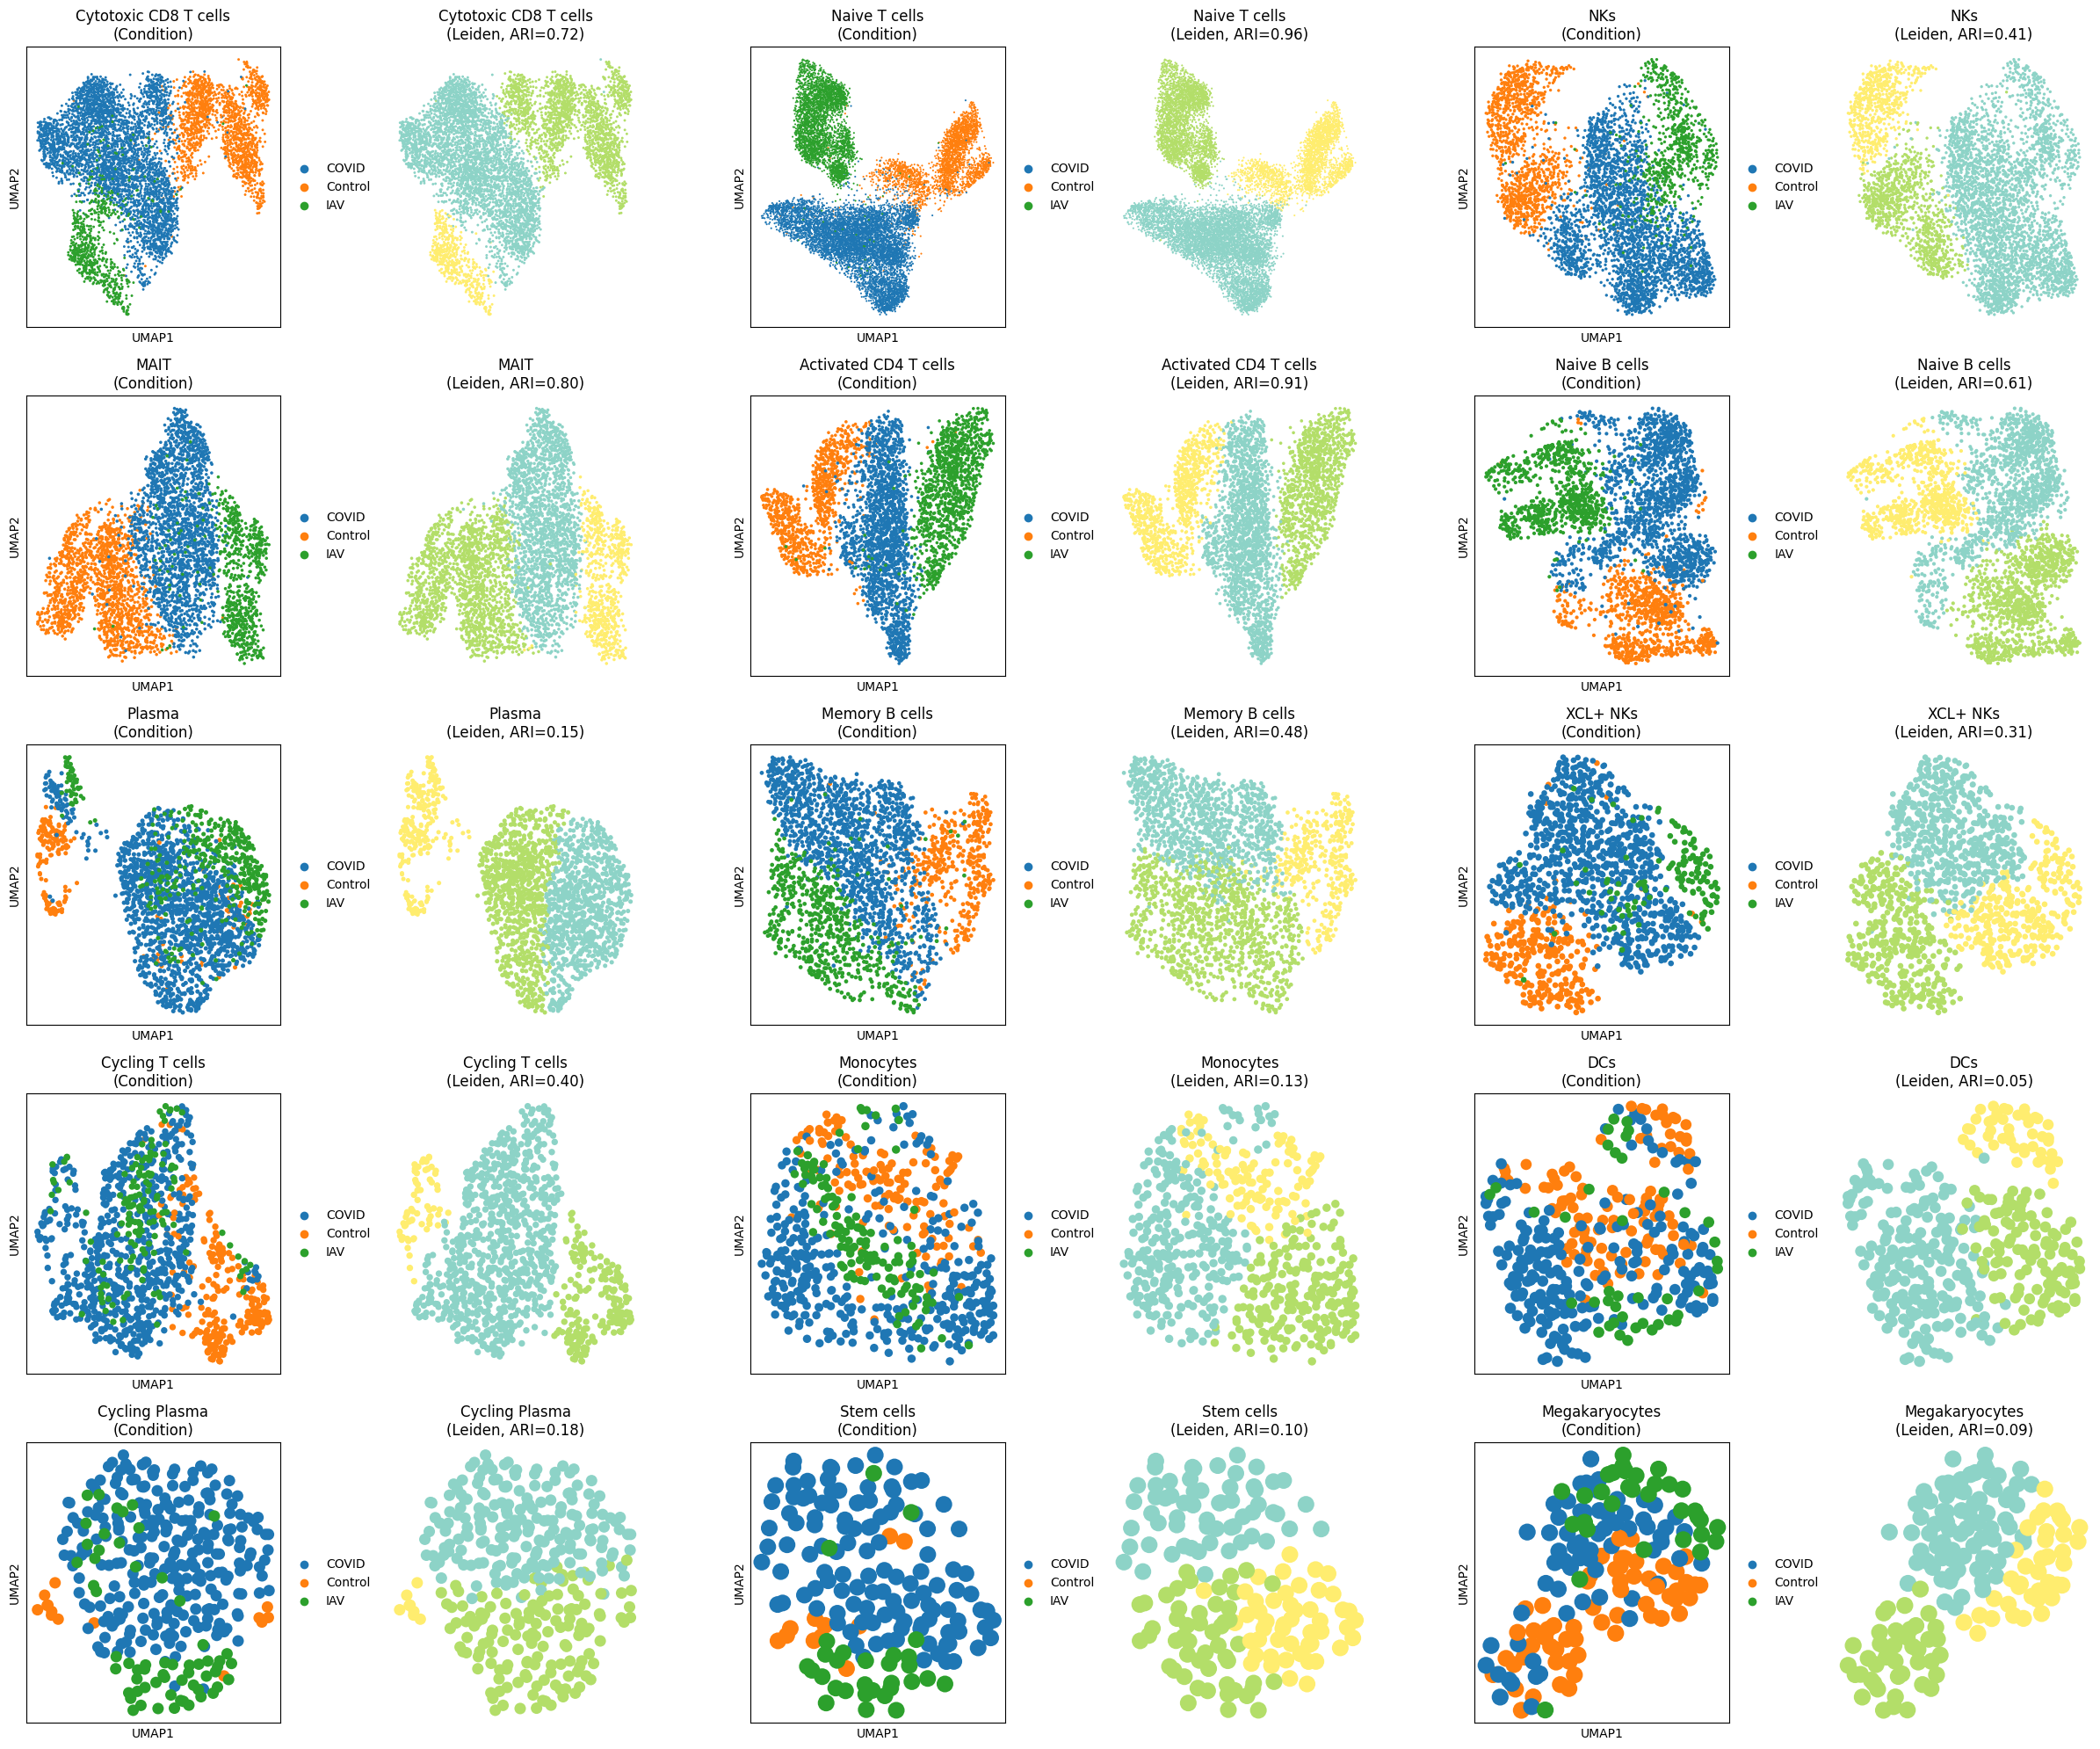

In [5]:
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
import numpy as np

# Define cell type mapping
cell_type_mapping = {
    0: "Cytotoxic CD8 T cells",
    1: "Naive T cells",
    2: "NKs",
    3: "MAIT",
    4: "Activated CD4 T cells",
    5: "Naive B cells",
    6: "Plasma",
    7: "Memory B cells",
    8: "XCL+ NKs",
    9: "Cycling T cells",
    10: "Monocytes",
    11: "DCs",
    12: "Cycling Plasma",
    13: "Stem cells",
    14: "Megakaryocytes",
}

# Parameters
target_n_clusters = 3
initial_resolution = 0.3
tolerance = 1
max_iterations = 10

n_cells = len(cell_type_mapping)
ncols = 6
nrows = (n_cells + 2) // 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
axes = axes.flatten()

ari_scores = {}

for i, (cell_id, cell_name) in enumerate(cell_type_mapping.items()):
    subset = adata[adata.obs["cell_type"] == cell_id].copy()
    
    if subset.n_obs < 5:
        continue

    # Preprocessing
    sc.pp.normalize_total(subset, target_sum=1e4)
    sc.pp.log1p(subset)
    sc.pp.pca(subset)
    sc.pp.neighbors(subset)
    sc.tl.umap(subset)

    # Find resolution that gives ~3 clusters
    resolution = initial_resolution
    for _ in range(max_iterations):
        print(f"Trying resolution: {resolution}")
        sc.tl.leiden(subset, resolution=resolution, key_added='leiden_temp')
        n_clusters = len(np.unique(subset.obs['leiden_temp']))
        print(f"Number of clusters: {n_clusters}")
        if n_clusters == target_n_clusters:
            print("="*50)
            break
        resolution *= 1.2 if n_clusters < target_n_clusters else 0.8
        

    # Save final clustering
    subset.obs['leiden'] = subset.obs['leiden_temp']

    # Compute ARI
    labels_true = subset.obs["condition"].values
    labels_pred = subset.obs["leiden"].values
    ari = adjusted_rand_score(labels_true, labels_pred)
    ari_scores[cell_name] = ari

    # Plot condition
    ax_cond = axes[2 * i]
    sc.pl.umap(subset, color="condition", ax=ax_cond, show=False,
               title=f"{cell_name}\n(Condition)")

    # Plot leiden
    ax_lei = axes[2 * i + 1]
    sc.pl.umap(subset, color="leiden", ax=ax_lei, show=False,
               title=f"{cell_name}\n(Leiden, ARI={ari:.2f})",
               palette='Set3', legend_loc=None, frameon=False)

# Clean up
for j in range(2 * n_cells, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


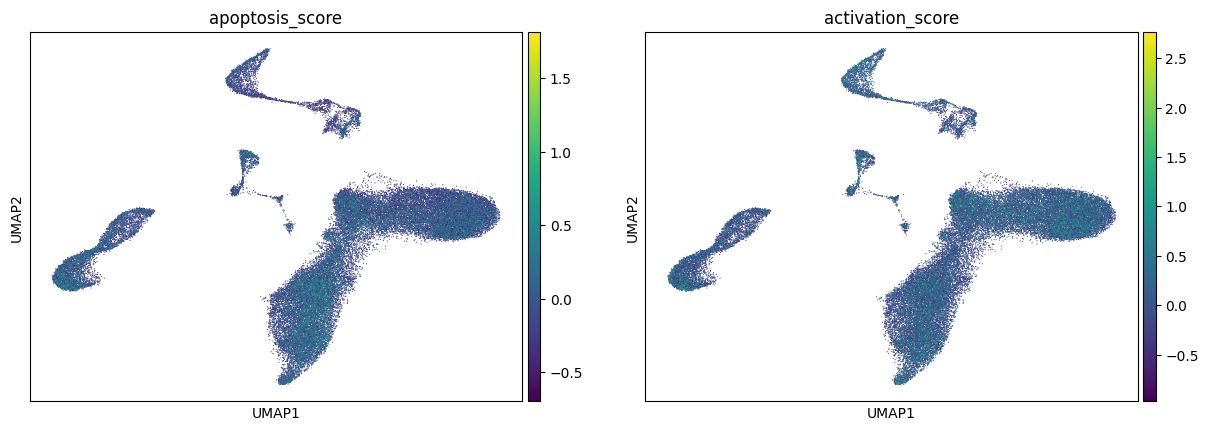

In [7]:
apoptosis_genes = ["XAF1", "TNF", "FAS", "BCL2L11", "CASP3"]
activation_genes = ["STAT1", "IL6R", "IRF3", "ISG15", "IFI44L"]

sc.tl.score_genes(adata, apoptosis_genes, score_name='apoptosis_score', use_raw=False)
sc.tl.score_genes(adata, activation_genes, score_name='activation_score', use_raw=False)

# Then you can plot:
sc.pl.umap(adata, color=['apoptosis_score', 'activation_score'])


Scoring based on genes: ['XAF1', 'TNF', 'FAS', 'BCL2L11', 'CASP3']


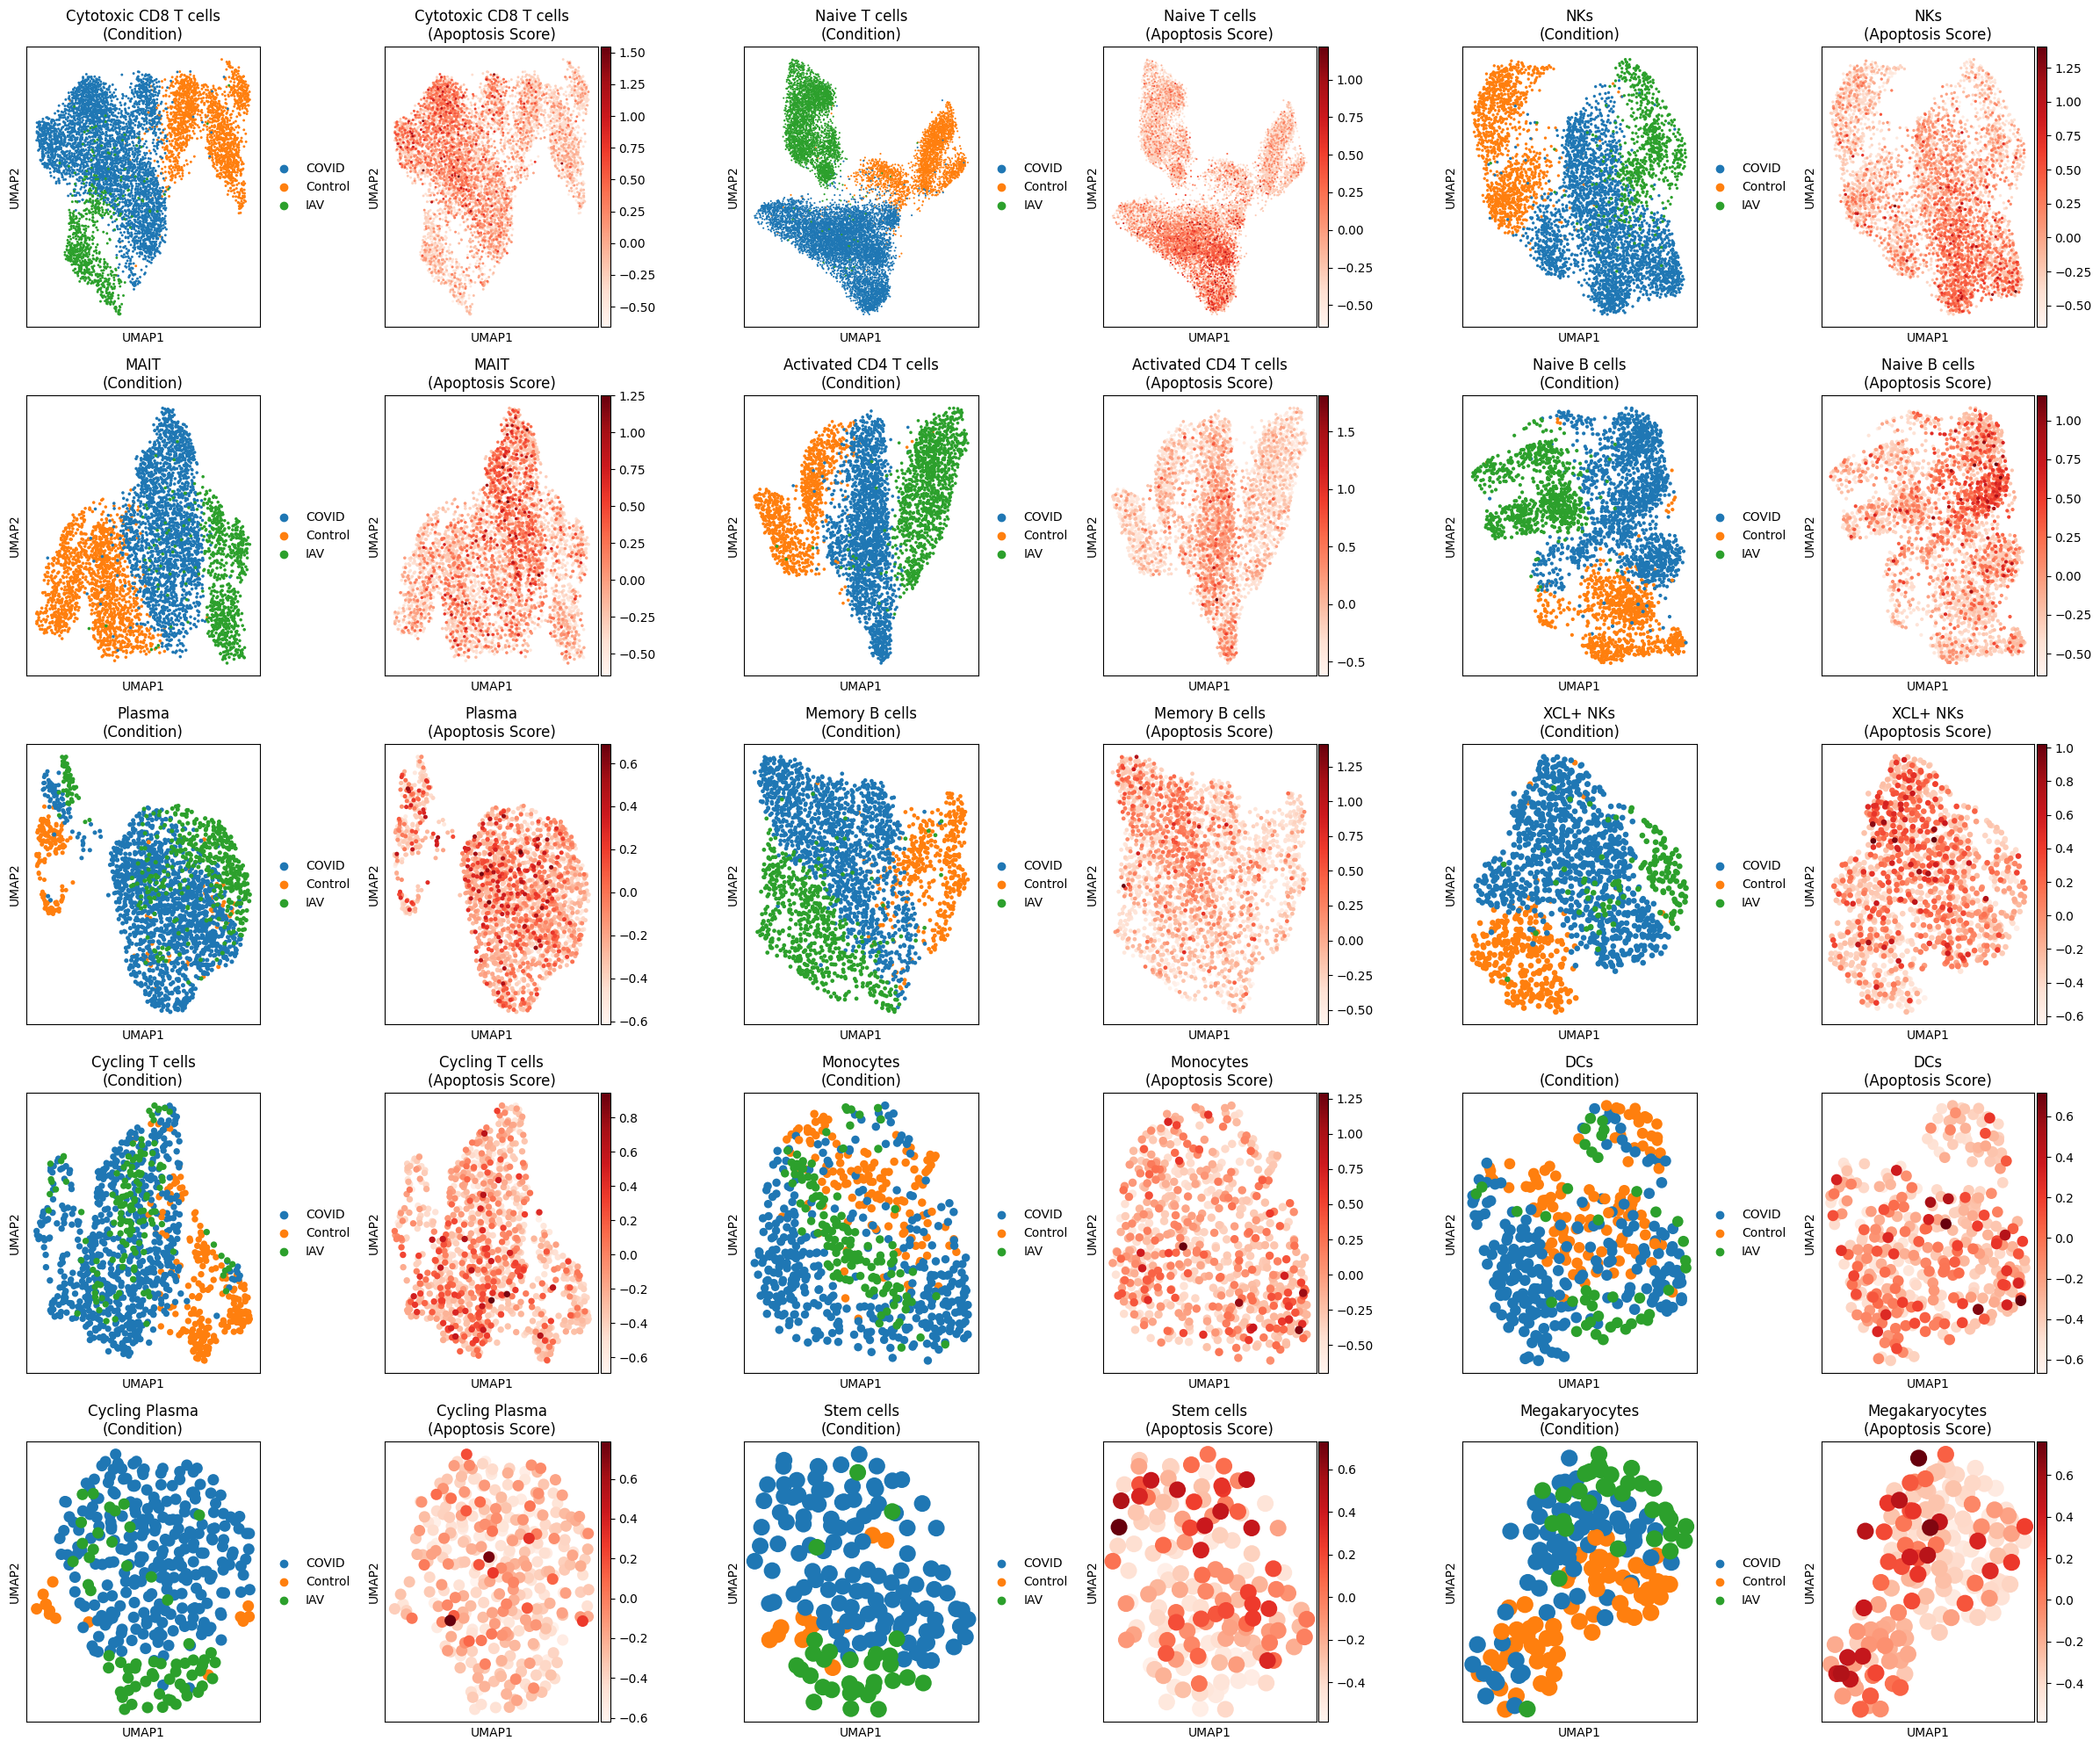

In [9]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# Define cell type mapping
cell_type_mapping = {
    0: "Cytotoxic CD8 T cells",
    1: "Naive T cells",
    2: "NKs",
    3: "MAIT",
    4: "Activated CD4 T cells",
    5: "Naive B cells",
    6: "Plasma",
    7: "Memory B cells",
    8: "XCL+ NKs",
    9: "Cycling T cells",
    10: "Monocytes",
    11: "DCs",
    12: "Cycling Plasma",
    13: "Stem cells",
    14: "Megakaryocytes",
}

# Step 1: Calculate apoptosis module score once on full adata
apoptosis_genes = ["XAF1", "TNF", "FAS", "BCL2L11", "CASP3"]

# Map gene names to indices if needed (depends on your adata.raw)
gene_to_index = {gene: idx for idx, gene in enumerate(adata.raw.var["_index"].values)}
valid_apoptosis_genes = [g for g in apoptosis_genes if g in gene_to_index]

print("Scoring based on genes:", valid_apoptosis_genes)

sc.tl.score_genes(adata, valid_apoptosis_genes, score_name="apoptosis_score", use_raw=False)

# Step 2: Plotting
n_cells = len(cell_type_mapping)
ncols = 6
nrows = (n_cells + 2) // 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
axes = axes.flatten()

for i, (cell_id, cell_name) in enumerate(cell_type_mapping.items()):
    subset = adata[adata.obs["cell_type"] == cell_id].copy()

    if subset.n_obs < 5:
        continue

    # Preprocessing
    sc.pp.normalize_total(subset, target_sum=1e4)
    sc.pp.log1p(subset)
    sc.pp.pca(subset)
    sc.pp.neighbors(subset)
    sc.tl.umap(subset)

    # Plot condition
    ax_cond = axes[2 * i]
    sc.pl.umap(subset, color="condition", ax=ax_cond, show=False,
               title=f"{cell_name}\n(Condition)")

    # Plot apoptosis score
    ax_apo = axes[2 * i + 1]
    sc.pl.umap(subset, color="apoptosis_score", ax=ax_apo, show=False,
               title=f"{cell_name}\n(Apoptosis Score)",
               color_map="Reds")

# Clean up
for j in range(2 * n_cells, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


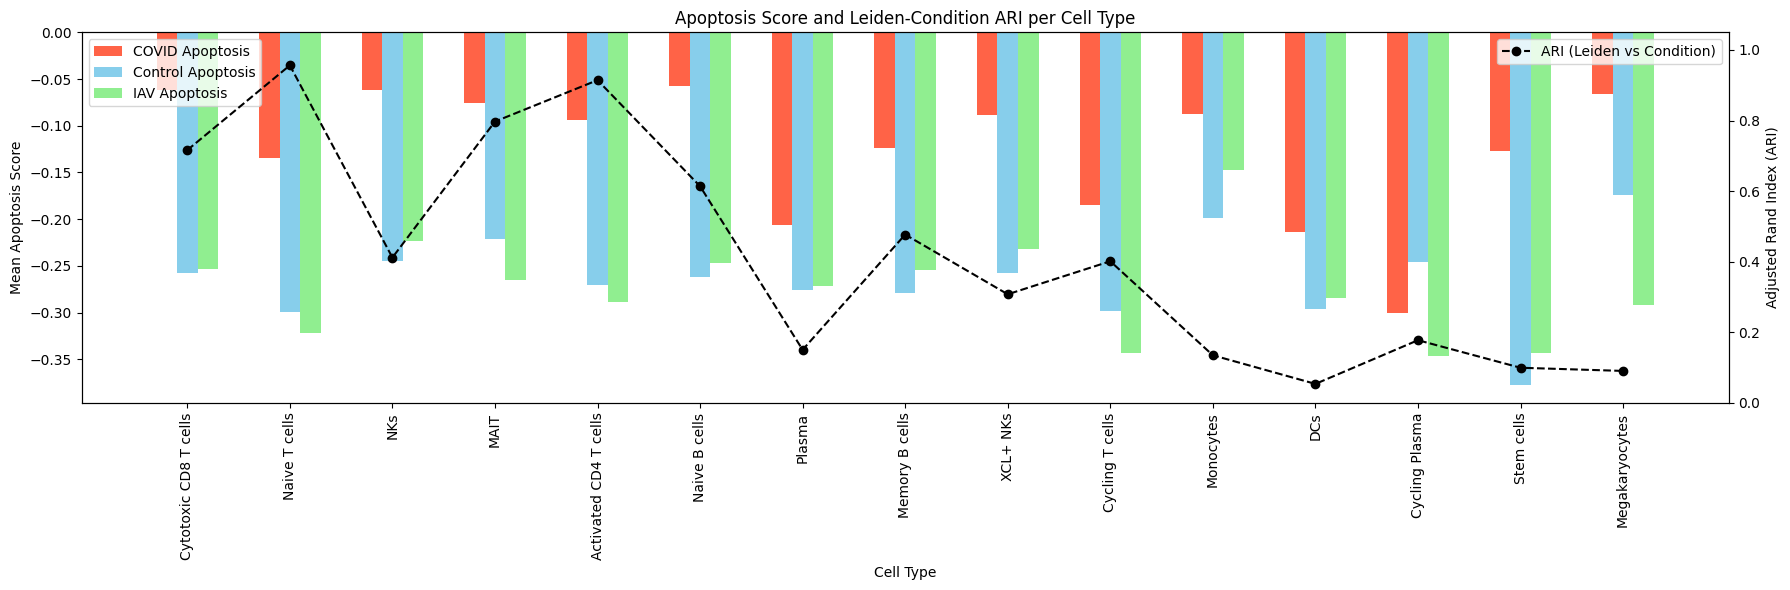

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
import scanpy as sc

# Your cell type mapping
cell_type_mapping = {
    0: "Cytotoxic CD8 T cells",
    1: "Naive T cells",
    2: "NKs",
    3: "MAIT",
    4: "Activated CD4 T cells",
    5: "Naive B cells",
    6: "Plasma",
    7: "Memory B cells",
    8: "XCL+ NKs",
    9: "Cycling T cells",
    10: "Monocytes",
    11: "DCs",
    12: "Cycling Plasma",
    13: "Stem cells",
    14: "Megakaryocytes",
}

# Parameters
target_n_clusters = 3
initial_resolution = 0.3
tolerance = 1
max_iterations = 10

# Storage
cell_types = []
apoptosis_covid = []
apoptosis_control = []
apoptosis_iav = []
ari_scores = []

# Iterate through cell types
for cell_id, cell_name in cell_type_mapping.items():
    print(f"Analyzing cell id: {cell_id}")
    subset = adata[adata.obs["cell_type"] == cell_id].copy()

    if subset.n_obs < 5:
        continue

    # Preprocessing
    sc.pp.normalize_total(subset, target_sum=1e4)
    sc.pp.log1p(subset)
    sc.pp.pca(subset)
    sc.pp.neighbors(subset)
    sc.tl.umap(subset)

    # Find resolution that gives ~3 clusters
    resolution = initial_resolution
    for _ in range(max_iterations):
        sc.tl.leiden(subset, resolution=resolution, key_added='leiden_temp')
        n_clusters = len(np.unique(subset.obs['leiden_temp']))
        if n_clusters == target_n_clusters:
            break
        resolution *= 1.2 if n_clusters < target_n_clusters else 0.8

    # Save final Leiden
    subset.obs['leiden_final'] = subset.obs['leiden_temp']

    # Calculate mean apoptosis scores
    covid_mean = subset.obs.loc[subset.obs["condition"] == "COVID", "apoptosis_score"].mean()
    control_mean = subset.obs.loc[subset.obs["condition"] == "Control", "apoptosis_score"].mean()
    iav_mean = subset.obs.loc[subset.obs["condition"] == "IAV", "apoptosis_score"].mean()

    # Calculate ARI
    labels_true = subset.obs["condition"].values
    labels_pred = subset.obs["leiden_final"].values
    ari = adjusted_rand_score(labels_true, labels_pred)

    # Store
    cell_types.append(cell_name)
    apoptosis_covid.append(covid_mean)
    apoptosis_control.append(control_mean)
    apoptosis_iav.append(iav_mean)
    ari_scores.append(ari)

# Create DataFrame
df = pd.DataFrame({
    "Cell Type": cell_types,
    "COVID Apoptosis": apoptosis_covid,
    "Control Apoptosis": apoptosis_control,
    "IAV Apoptosis": apoptosis_iav,
    "ARI": ari_scores
})

# === Plotting ===

fig, ax1 = plt.subplots(figsize=(18, 6))

bar_width = 0.2
x = np.arange(len(df))

# Plot apoptosis scores
ax1.bar(x - bar_width, df["COVID Apoptosis"], width=bar_width, label="COVID Apoptosis", color='tomato')
ax1.bar(x, df["Control Apoptosis"], width=bar_width, label="Control Apoptosis", color='skyblue')
ax1.bar(x + bar_width, df["IAV Apoptosis"], width=bar_width, label="IAV Apoptosis", color='lightgreen')

ax1.set_ylabel("Mean Apoptosis Score")
ax1.set_xlabel("Cell Type")
ax1.set_xticks(x)
ax1.set_xticklabels(df["Cell Type"], rotation=90)
ax1.legend(loc="upper left")

# Secondary axis for ARI
ax2 = ax1.twinx()
ax2.plot(x, df["ARI"], color="black", marker="o", linestyle="--", label="ARI (Leiden vs Condition)")
ax2.set_ylabel("Adjusted Rand Index (ARI)")
ax2.set_ylim(0, 1.05)

# Add ARI legend
ax2.legend(loc="upper right")

plt.title("Apoptosis Score and Leiden-Condition ARI per Cell Type")
plt.tight_layout()
plt.show()


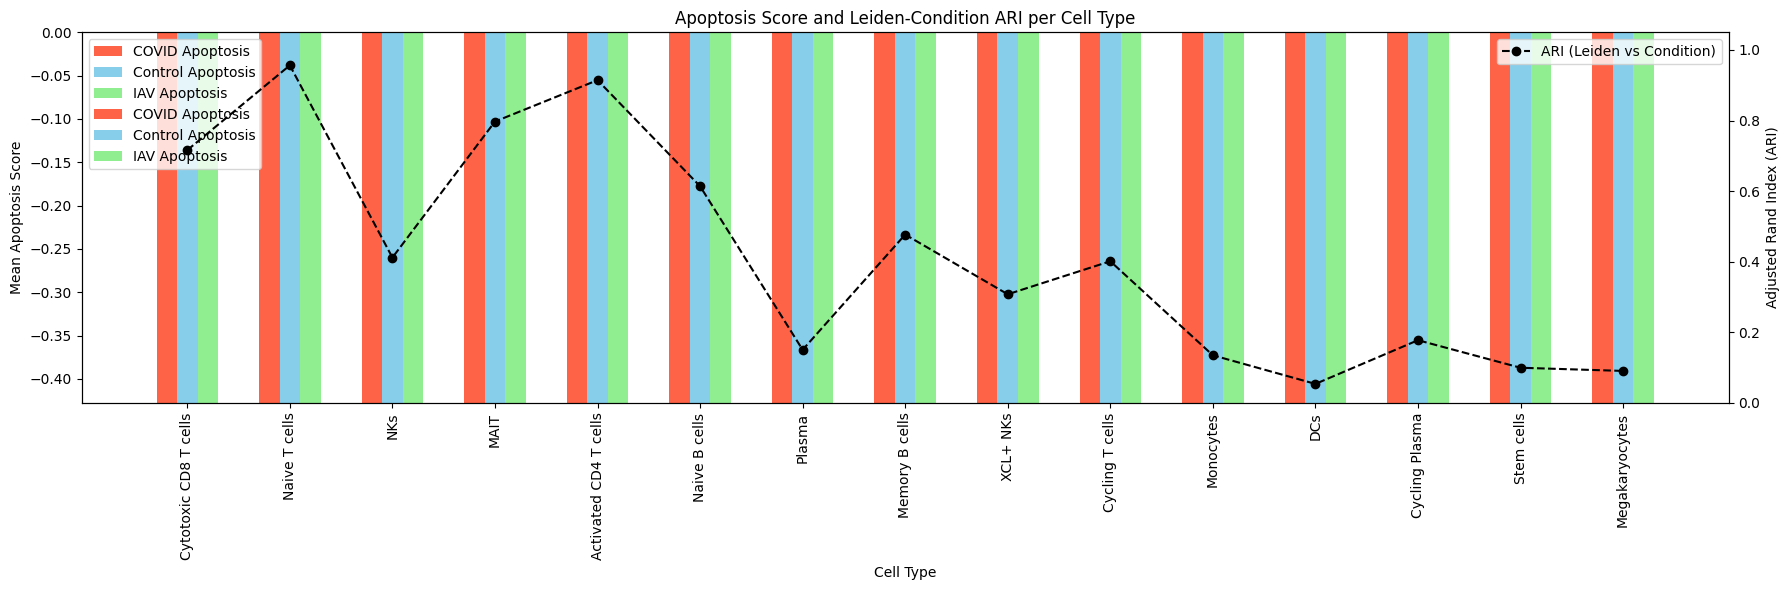

In [16]:
fig, ax1 = plt.subplots(figsize=(18, 6))

bar_width = 0.2
x = np.arange(len(df))

# Plot apoptosis scores
ax1.bar(x - bar_width, df["COVID Apoptosis"], width=bar_width, label="COVID Apoptosis", color='tomato')
ax1.bar(x, df["Control Apoptosis"], width=bar_width, label="Control Apoptosis", color='skyblue')
ax1.bar(x + bar_width, df["IAV Apoptosis"], width=bar_width, label="IAV Apoptosis", color='lightgreen')

# Proper y-axis
min_y = df[["COVID Apoptosis", "Control Apoptosis", "IAV Apoptosis"]].min().min() - 0.05

# Adjust the bars so they start from min_y
ax1.bar(x - bar_width, df["COVID Apoptosis"] - min_y, bottom=min_y, width=bar_width, label="COVID Apoptosis", color='tomato')
ax1.bar(x, df["Control Apoptosis"] - min_y, bottom=min_y, width=bar_width, label="Control Apoptosis", color='skyblue')
ax1.bar(x + bar_width, df["IAV Apoptosis"] - min_y, bottom=min_y, width=bar_width, label="IAV Apoptosis", color='lightgreen')

# Proper y-axis
ax1.set_ylim(min_y, 0)
ax1.set_ylabel("Mean Apoptosis Score")

ax1.set_xlabel("Cell Type")
ax1.set_xticks(x)
ax1.set_xticklabels(df["Cell Type"], rotation=90)
ax1.legend(loc="upper left")

# Secondary axis for ARI
ax2 = ax1.twinx()
ax2.plot(x, df["ARI"], color="black", marker="o", linestyle="--", label="ARI (Leiden vs Condition)")
ax2.set_ylabel("Adjusted Rand Index (ARI)")
ax2.set_ylim(0, 1.05)

ax2.legend(loc="upper right")

plt.title("Apoptosis Score and Leiden-Condition ARI per Cell Type")
plt.tight_layout()
plt.show()


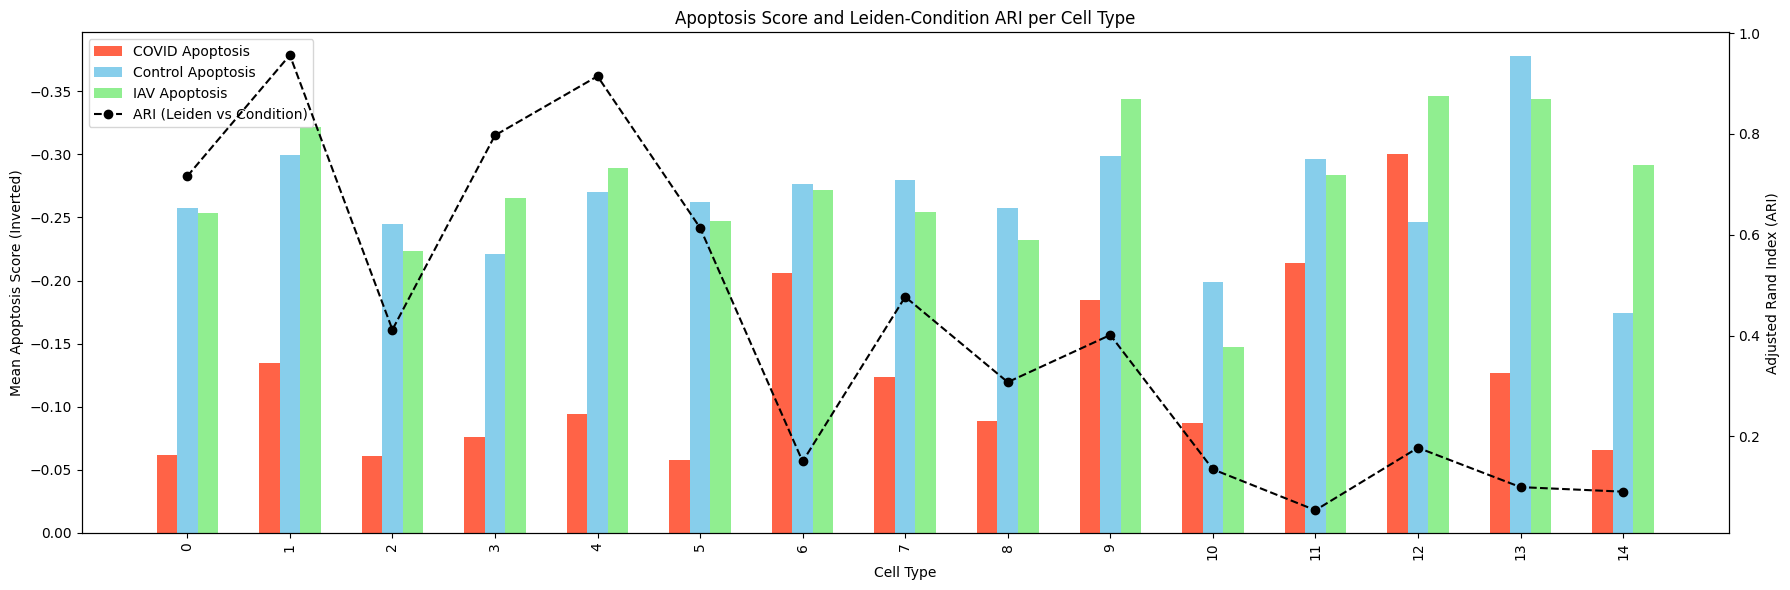

In [17]:
# Plot normally (no min_y shifting needed)
bar_width = 0.2
x = np.arange(len(df.index))

fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot apoptosis bars
ax1.bar(x - bar_width, df["COVID Apoptosis"], width=bar_width, label="COVID Apoptosis", color='tomato')
ax1.bar(x, df["Control Apoptosis"], width=bar_width, label="Control Apoptosis", color='skyblue')
ax1.bar(x + bar_width, df["IAV Apoptosis"], width=bar_width, label="IAV Apoptosis", color='lightgreen')

# Plot ARI on secondary axis
ax2 = ax1.twinx()
ax2.plot(x, df["ARI"], color='black', marker='o', linestyle='--', label="ARI (Leiden vs Condition)")

# Adjust x-axis
ax1.set_xticks(x)
ax1.set_xticklabels(df.index, rotation=90)
ax1.set_xlabel("Cell Type")

# Invert primary y-axis so bigger apoptosis scores are higher
ax1.invert_yaxis()

ax1.set_ylabel("Mean Apoptosis Score (Inverted)")
ax2.set_ylabel("Adjusted Rand Index (ARI)")

# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.title("Apoptosis Score and Leiden-Condition ARI per Cell Type")
plt.tight_layout()
plt.show()


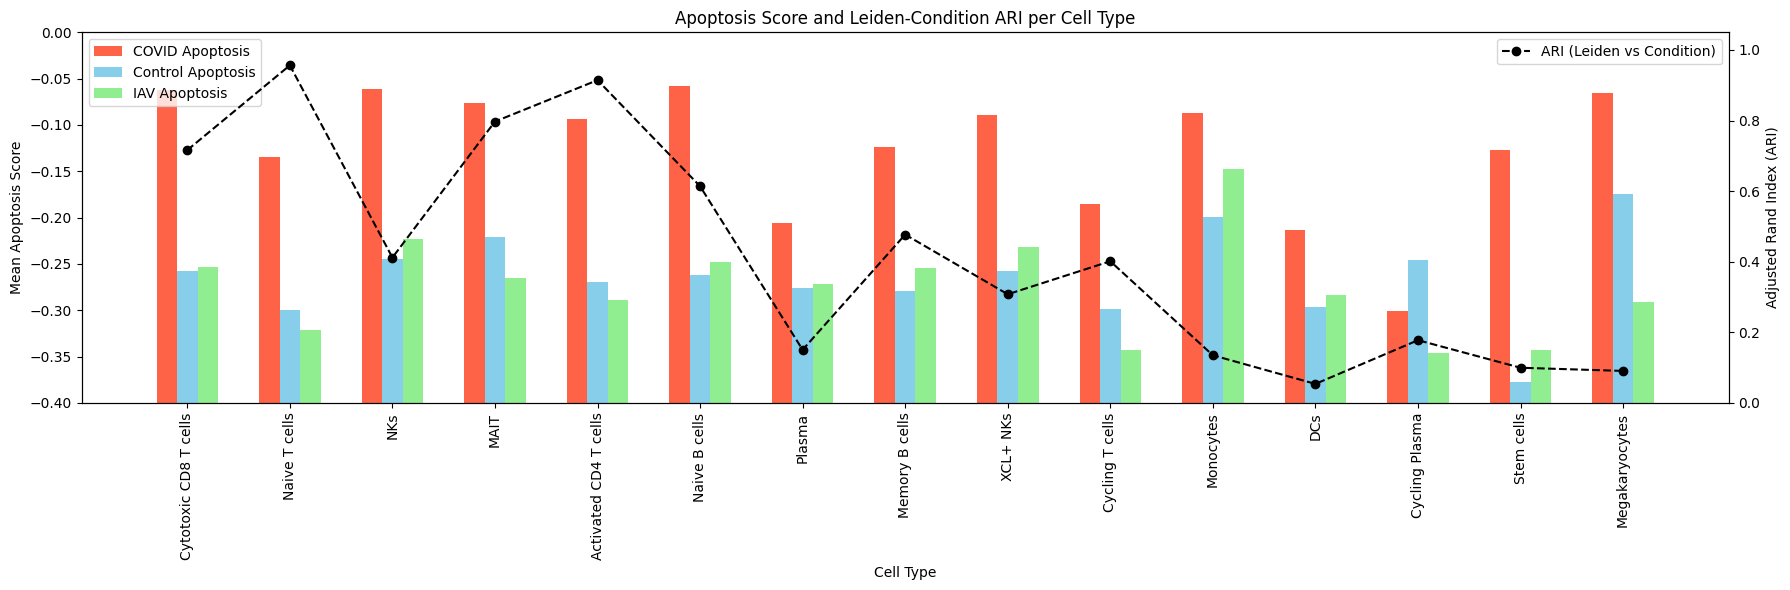

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Set bar width and x locations
bar_width = 0.2
x = np.arange(len(df))

# Set your minimum y value
min_y = -0.4

fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot each group manually setting "bottom" and "height"
ax1.bar(x - bar_width, df["COVID Apoptosis"] - min_y, width=bar_width, 
        bottom=min_y, label="COVID Apoptosis", color='tomato')
ax1.bar(x, df["Control Apoptosis"] - min_y, width=bar_width, 
        bottom=min_y, label="Control Apoptosis", color='skyblue')
ax1.bar(x + bar_width, df["IAV Apoptosis"] - min_y, width=bar_width, 
        bottom=min_y, label="IAV Apoptosis", color='lightgreen')

# Set y-axis limits from min_y to 0
ax1.set_ylim(min_y, 0)

# Label axes
ax1.set_ylabel("Mean Apoptosis Score")
ax1.set_xlabel("Cell Type")
ax1.set_xticks(x)
ax1.set_xticklabels(df["Cell Type"], rotation=90)

# Add legend
ax1.legend(loc="upper left")

# Secondary axis for ARI
ax2 = ax1.twinx()
ax2.plot(x, df["ARI"], color="black", marker="o", linestyle="--", label="ARI (Leiden vs Condition)")
ax2.set_ylabel("Adjusted Rand Index (ARI)")
ax2.set_ylim(0, 1.05)
ax2.legend(loc="upper right")

# Title and layout
plt.title("Apoptosis Score and Leiden-Condition ARI per Cell Type")
plt.tight_layout()
plt.show()
